John Ryan Kivela, MA

UMass Boston

College of Management

MSIS - 672 Final Project

Data Preprocessing

5/4/24

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer

In [2]:
# Load Data
df_hot = pd.read_csv('Kivela - Final Exam Preprocessed.csv')

In [3]:
## Define Variables
TargetVariable = 'Credit_Mix'

X = df_hot.drop(columns = TargetVariable)
y = df_hot[TargetVariable]

In [4]:
## split the preprocessed data into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, 
                                                      y, 
                                                      test_size = 0.3, 
                                                      train_size = 0.7, 
                                                      random_state = 373
                                                     )

In [5]:
# Create a tree model with defaults
clf = DecisionTreeClassifier(criterion="gini", 
                               #splitter="best", 
                               max_depth=None, 
                               min_samples_split=2, 
                               #min_samples_leaf=1, 
                               #min_weight_fraction_leaf=0.0, 
                               #max_features=None, 
                               random_state=373, 
                               #max_leaf_nodes=None, 
                               min_impurity_decrease=0.0, 
                               #class_weight=None, 
                               #ccp_alpha=0.0
                            )

In [6]:
# Fit (train) the model
clf.fit(X = train_X,
        y = train_y,
        #sample_weight=None,
        #check_input=True
       )

DecisionTreeClassifier(random_state=373)

In [7]:
# Set some names
FeatureNames = list(valid_X.columns)
ClassNames = list(clf.classes_)

In [8]:
# Cross-validation on the training set
cv_scores = cross_val_score(clf, X, y, cv=5)

print("Cross-validation scores on training set:", cv_scores)
print("Mean CV accuracy on training set:", cv_scores.mean())
# CV accuracy = estimate of how well the model generalizes to new data.

Cross-validation scores on training set: [0.91267571 0.90334619 0.90769996 0.9089439  0.90023635]
Mean CV accuracy on training set: 0.9065804204503047


                          feature  importance       std
16     Payment_of_Min_Amount_True    0.002760  0.074174
17  Payment_of_Min_Amount_Unknown    0.004050  0.074174
14                Monthly_Balance    0.006373  0.074174
11       Credit_Utilization_Ratio    0.007451  0.074174
13        Amount_invested_monthly    0.008134  0.074174
9            Num_Credit_Inquiries    0.008412  0.074174
1           Monthly_Inhand_Salary    0.009861  0.074174
5                     Num_of_Loan    0.010989  0.074174
0                   Annual_Income    0.011018  0.074174
12            Total_EMI_per_month    0.011296  0.074174
3                 Num_Credit_Card    0.015778  0.074174
8            Changed_Credit_Limit    0.045456  0.074174
7          Num_of_Delayed_Payment    0.072606  0.074174
2               Num_Bank_Accounts    0.090176  0.074174
6             Delay_from_due_date    0.100558  0.074174
4                   Interest_Rate    0.121600  0.074174
10               Outstanding_Debt    0.212712  0

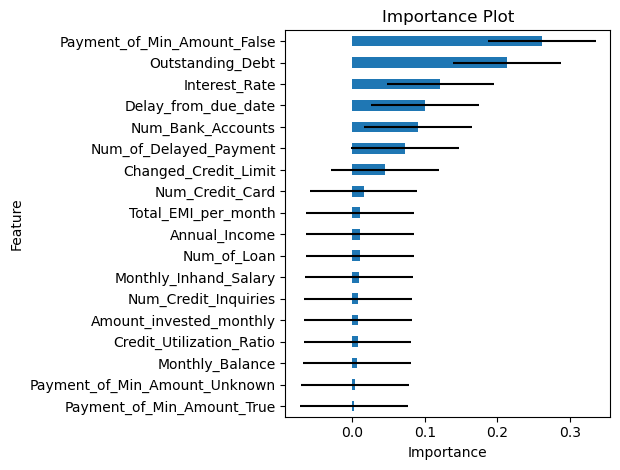

In [9]:
## Variable/Feature Importance Plot Data Frame
importances = clf.feature_importances_

# Get standard deviation
std = np.std(importances, 
             axis = 0, 
             dtype=None, 
             out=None, 
             ddof=0, 
             keepdims=False,
             # where=None
             )

# Describe Importances
importance_plot_df = pd.DataFrame({'feature': FeatureNames, 
                                   'importance': importances, 
                                   'std': std})

importance_plot_df = importance_plot_df.sort_values('importance')

print(importance_plot_df)

## Importance Plot
ax = importance_plot_df.plot(kind='barh', 
                             xerr='std', 
                             x='feature', 
                             legend=False)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Importance Plot')
plt.tight_layout()
plt.show()

In [10]:
# Initial Parameter grid tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_impurity_decrease':[0, 1],
    'min_samples_split': [2, 5, 10]
}

In [11]:
# GridsearchCV
gridSearch = GridSearchCV(clf, 
                           param_grid, 
                           cv=5)

# fit gridsearch to training data
gridSearch.fit(X, y)

# Print best parameters and best score
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  0.9285732056225898
Initial parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 2}


In [12]:
# Updated Parameter grid tuning (wash, rinse, repeat)
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [8],
    'min_impurity_decrease': [.00001],
    'min_samples_split': [200]
}

In [13]:
# Updated GridsearchCV (wash, rinse, repeat)
gridSearch = GridSearchCV(clf, 
                           param_grid, 
                           cv=5)

# fit gridsearch to training data
gridSearch.fit(X, y)

# Print best parameters and best score
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

Best score:  0.9170792387112824
Best parameters:  {'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 1e-05, 'min_samples_split': 200}


In [14]:
# Evaluate the final model on validatoipn data
best_clf = gridSearch.best_estimator_
y_pred = best_clf.predict(valid_X)
valid_accuracy = best_clf.score(valid_X, valid_y)

print("Accuracy on validation set:", valid_accuracy)

Accuracy on validation set: 0.9231279542250601


Classification Report:
              precision    recall  f1-score   support

         Bad       0.94      0.92      0.93      2819
        Good       0.94      0.92      0.93      3718
    Standard       0.91      0.93      0.92      5522

    accuracy                           0.92     12059
   macro avg       0.93      0.92      0.92     12059
weighted avg       0.92      0.92      0.92     12059

Confusion Matrix:
[[2591    0  228]
 [   1 3408  309]
 [ 164  225 5133]]


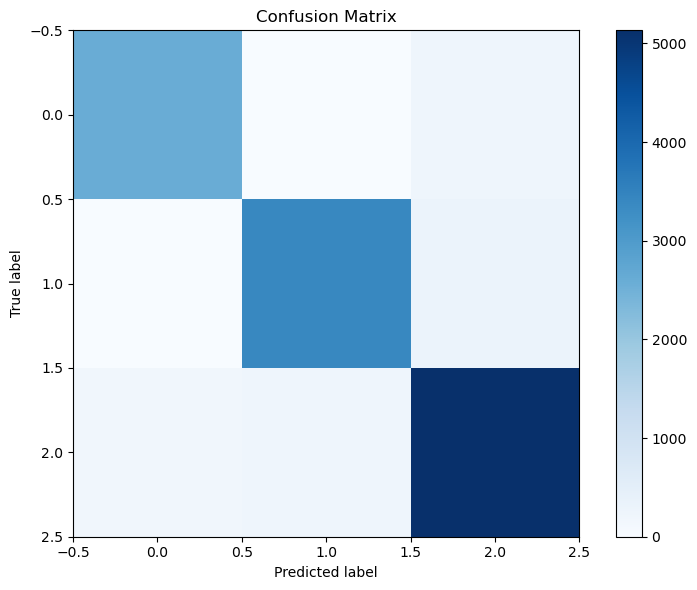

In [15]:
# Classification report
print("Classification Report:")
print(classification_report(valid_y, y_pred, target_names=ClassNames))

# Confusion matrix
print("Confusion Matrix:")
conf_mat = confusion_matrix(valid_y, y_pred)
print(conf_mat)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Store confusion matrix in variable conf_mat
conf_mat = plt

plt.show()

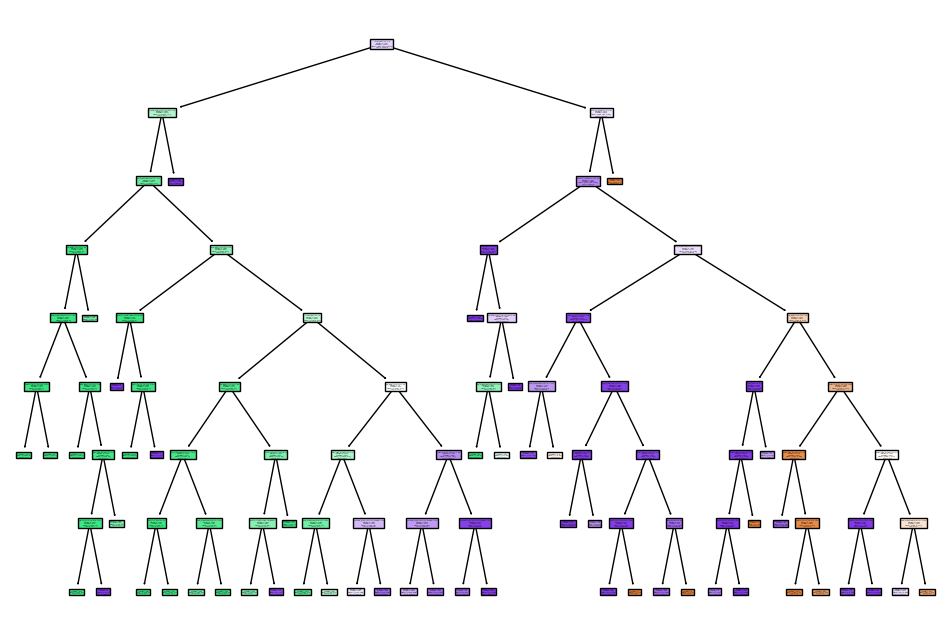

In [16]:
# Plot decision tree

# Set some names
FeatureNames = list(valid_X.columns)
ClassNames = list(clf.classes_)

plt.figure(figsize = (12, 8))
plot_tree(best_clf, 
          feature_names = FeatureNames, 
          class_names = ClassNames, 
          filled = True)
plt.show()